In [2]:
# 불러올 수많은 모듈들..
import json
from tokenization_kobert import KoBertTokenizer

import os
import time
import datetime
import random

import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import AdamW
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import IPython

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [3]:
# 토크나이저 선언
tokenizer = KoBertTokenizer.from_pretrained("monologg/kobert")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [4]:
# gpu 메모리 청소
torch.cuda.empty_cache()

# device = gpu 설정
if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('%d개 존재함' % torch.cuda.device_count())
    print('사용할 GPU : ', torch.cuda.get_device_name(0))

# If not...
else:
    print('GPU 없어서 CPU로 설정')
    device = torch.device("cpu")

1개 존재함
사용할 GPU :  NVIDIA GeForce RTX 3060


In [5]:
with open('dongwon_data/동원몰 챗봇_☆상용서버☆Live-dialog.json', 'r',encoding="utf-8") as f:
    json_data = json.load(f)

In [6]:
# intent_list 생성
intent_list = []
for x in json_data["intents"]:
    intent_list.append(x["intent"])

In [6]:
### 최소 선언 영역 ##

In [7]:
# intent_dic 생성
intent_dic = {}
for i,x in enumerate(intent_list):
    intent_dic[x] = i

In [8]:
# intent_content 생성
intent_content = []

for x in json_data["intents"]:
    for y in x["examples"]:
        intent_content.append([tokenizer.tokenize(y["text"]),intent_dic[x["intent"]]])

In [9]:
# 요소 하나 확인
print(intent_content[2])

[['▁', '짱'], 0]

In [10]:
# cls sep 토큰 추가(사실 뒤에 special token 채워서 상관없을거 같은데 그냥 넣어봄)

for x in intent_content:
    x[0].insert(0,"[CLS]")
    x[0].append("[SEP]")

In [11]:
# 요소 하나 확인2
intent_content[0]

[['[CLS]', '▁', '굳', '[SEP]'], 0]

In [12]:
# 단어, 개체명 리스트 2개 분리
token_word = [x[0] for x in intent_content]
token_num = [x[1] for x in intent_content]

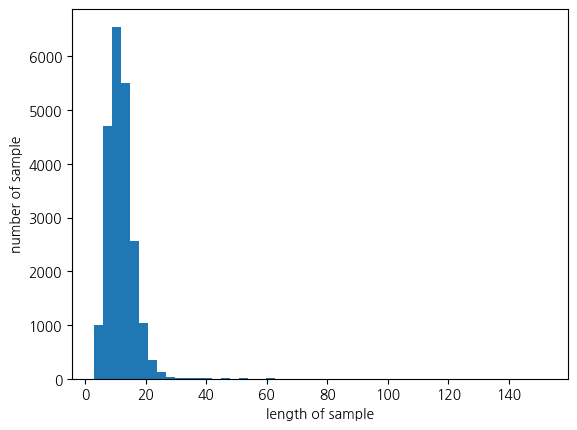

최대 길이 : 152
최소 길이 : 3
평균 길이 : 11.410429


In [13]:
# 문장 길이 현황 확인
max_len = max(len(x) for x in token_word)

plt.hist([len(x) for x in token_word], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

print('최대 길이 : %d' % max_len)
print('최소 길이 : %d' % min(len(x) for x in token_word))
print('평균 길이 : %f' % (sum(map(len, token_word))/len(token_word)))

In [14]:
# max_len : 152로 일단 고정

In [15]:
# # 4분위수
# import numpy as np

# print(np.quantile(np.array([len(x) for x in token_word]), 0.9))

In [16]:
# input, attention 만들기
input_ids = []
attention_masks = []

for x in token_word:
    encoded_dict = tokenizer.encode_plus(
        x,
        add_special_tokens = True, # 이미 스페셜 토큰 넣긴했지만 일단 설정함
        max_length = max_len, # 최대길이
        pad_to_max_length = True, # 최대길이 넘으면 패딩처리
        return_attention_mask = True, # 어텐션 마스크 설정
        return_tensors = "pt" # 파이토치 텐서로 출력
    )

    input_ids.append(encoded_dict["input_ids"]) # ids
    attention_masks.append(encoded_dict["attention_mask"]) # attention mask

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\YU\miniconda3\envs\py38\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
print("0번째 모양 :", input_ids[0])
print("크기 :", input_ids[0].size())
print("개수 :",len(input_ids))
print("==================")
print("0번째 모양 :", attention_masks[0])
print("크기 :",attention_masks[0].size())
print("개수 :",len(attention_masks))
print("==================")
print("0번째 모양 :", token_num[0])
print("개수 :",len(token_num))

0번째 모양 : tensor([[   2,    2,  517, 5515,    3,    3,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1

In [19]:
# 텐서들로 이루어져있는 리스트 -> 하나의 텐서로 만들기
input_ids = torch.cat(input_ids, dim=0) #  dim = 0 으로 전환
attention_masks = torch.cat(attention_masks, dim=0) #  dim = 0 으로 전환
labels = torch.tensor(token_num) # 한줄 리스트라 이미 dim=0임

In [20]:
# tensordataset 모듈을 사용해서 합치기
dataset = TensorDataset(input_ids, attention_masks, labels)

# 8:1:1 형태로 train,test,val 개수(크기) 지정
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset)) 
test_size = len(dataset) - train_size - val_size

# 지정한 크기에 맞게 랜덤하게 분리해서 저장
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"train : {train_size}")
print(f"valid : {val_size}")
print(f"test : {test_size}")

train : 17550
valid : 2193
test : 2195


In [21]:
# 임의로 배치 사이즈 지정
batch_size = 32

# 데이터 로더 -> 배치사이즈에 맞게 잘 섞고 iter 형태로 전환
# valid, test는 굳이 섞을 필요가 없음(고정되있는게 오히려 비교하기 좋음)
# train
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# valid
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# test
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [23]:
# 모델 만들기
model_name = "monologg/kobert"

# 모델 설정 불러오기
config = AutoConfig.from_pretrained(model_name)

# 모델 라벨 개수 지정
config.num_labels = len(intent_dic)

# 모델에 attentions 존재함
config.output_attentions = True

In [24]:
# # 모델 설정 확인하려면
# print("config", config)

In [25]:
# 모델 불러오기(모델+설정)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config)

# 쿠다 사용할거야
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [26]:
# # 튜플모형으로 모든 파라미터를 확인 가능함(레이어별로)
# params = list(model.named_parameters())

# print('The model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Transformer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== Output Layer ====\n')

# for p in params[-4:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [27]:
# adamw 라는 새로운 옵티마이저 사용함
# https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html
# 해보니깐 adam 도 마냥 만능이 아니라서 여러가지로 개선할 방법을 강구하는 과정에서 나온 것들

optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # 학습률
                  eps = 1e-8 # 아담 엡실론
                )

c:\Users\YU\miniconda3\envs\py38\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
len(train_dataloader)

549

In [29]:
# 반복 횟수 지정
epochs = 10
# train_dataset / batch_size = 548.4... = 549 = len(train_dataloader) = train step 수 
# 1 epoch당 train 기준 549번 step 밟음 -> 10epoch = 5490
total_steps = len(train_dataloader) * epochs

# 학습률 줄이는데에 시간이 오래걸리므로 처음 lr크기를 크게준후 epoch 마다 값을 감소시켜서 빠르게 도달하기
# 아니면 학습률 증가 -> 학습률 감소 식으로도 구현 가능
# cosine , linear, inverse_sqrt, constant ....

# 그중에서 우리는 1-cycle 스케줄링을 사용함 => linear하게 증가, 감소함.(옵티마이저는 그대로, )
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps=total_steps)

# 1-cycle 스케줄링의 경우
# num_warmup_steps : 이 step수에 해당할때까지 0부터 선형적으로 증가
# ex) 100 이면, 100에 이를때까지 0부터 linear하게 증가
# 100에 도달하고 그 이후부터는 linear하게 감소
# 그래서 일반적으로 train_dataloader 개수에 1/10 으로 지정하는 등으로 함
# # num_training_steps : 전체 step 수

## 저기서 num_warmup_steps 조정하면 적용된다는 뜻임

In [29]:
# 실제값을이용하여 예측값의 정확도를 계산하는 함수 선언
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # 한줄로 나열
    labels_flat = labels.flatten() # 한줄로 나열2
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    # (틀리면0, 맞으면 1/전체 개수)의 총합 = ac 확률

In [ ]:
# 데이터 분포가 불균형적이면, f1_score
# 데이터 분포가 균형적이면, acc

# 궁극적으로 구현해보고 싶은거
# warm_steps 조절해서 성능에 미치는 영향
# f1_score(micro)로 계산하게 동작
# test시 전체 분류표도 출력되게 동작

In [25]:
# 시간을 재봐요 함수

def format_time(elapsed):
    # 반올림해서 정수로 표현
    elapsed_rounded = int(round((elapsed)))
    
    # 시간/분/초로 출력되게 하자
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [47]:
# 랜덤시드 설정

# 근데 위에서 데이터 섞을때는 시드 없이 섞어서 사실상 무용지물임ㅋㅋ
seed_val = 2022

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# train,valid loss 와 valid acc 와 타임 로그도 저장할거야
training_stats = []

# 전체 걸린 시간 측정
total_t0 = time.time()

# 에포크 마다 돌려돌려
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 1에포크당 걸린 시간 측정
    t0 = time.time()

    # 전체 손실 값 초기화
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train() # train 모드로 전환한다는 뜻임(학습시작이 아님)

    # batch 마다 돌려돌려
    for step, batch in enumerate(train_dataloader):

        # 50 스텝마다 
        if step % 50 == 0 and not step == 0:
            # 처음 시작에서 지나간 시간을 측정
            elapsed = format_time(time.time() - t0)
            
            # 과정 출력
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 순서대로 ids, mask, labels이 담겨있음(batch 하나에)
        b_input_ids = batch[0].to(device) 
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        # 미분 기울기는 항상 초기화해야해
        # 안그러면 학습할때마다 계속 기존의 미분 기울기에 적용되서 이상해져버려
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        # 모델에 돌릴거야(순전파)
        M = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        loss = M.loss
        logits = M.logits
        attentions = M.attentions

        # 나오는 loss값을 다 전체 손실값에 더할거야
        total_train_loss += loss.item()

        # 반대로 돌아가서 기울기를 역 계산하기(역전파)
        loss.backward()

        # 출력 길이에 따라 기울기 크기가 너무 커질수도 있으므로 해결하고자 하는 방법 중 하나
        # 쉬운 방법은 학습률을 작게 취하기(길이가 달라지므로 그에 맞는 학습률이 동적으로 변화 -> adam)'Adam
        # 그러나 일단 혹시 오버되는 일말의 문제에도 대처하기 위해서 작성함

        # 기울기 벡터 방향은 유지 + 크기만 적절하게 조절((1)보다 크면 동작함)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 역전파에서 계산한 기울기들을 각각 파라미터에 적용
        optimizer.step()

        # 학습률도 스케줄러에 설정한 옵션에 맞게 조정
        scheduler.step()

    # 1에포크마다 평균 train_loss를 구함(loss 총합/전체개수)
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # 1에포크까지 나온 시간 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  평균 training loss: {0:.2f}".format(avg_train_loss))
    print("  Training 1 epoch 걸린 시간: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # 학습이 다 끝난후 valid 데이터 가지고 성능이 어느정도인지 확인

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 평가 모드로 전환(+ dropout, batchnorm 비활성화해줌)
    # 메모리는 그대로
    model.eval()

    # torch.no_grad()을 사용하면 자동미분 계산기능을 아예 꺼버려서 메모리 줄이고 연산속도가 증가함
    # 대신 dropout 같은 요소들을 비활성화 하지 않음
    # 그래서 model.eval()로 드랍아웃 끄고, torch.no_grad()을 씌워서 메모리도 줄이는 형태로 되어있음

    # 변수들을 추적하자
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # 1에포크 시점
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 순전파 돌린 값만을 보고 측정하기 떄문에 autograd 엔진 끔
        with torch.no_grad():   
            M = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
            loss = M.loss
            logits = M.logits
            attentions = M.attentions
            
        # valid loss 값 다 더해
        total_eval_loss += loss.item()

        # 결과 logits, 결과 라벨 -> cpu에 할당
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 전체 acc 값에다 acc 계산 함수값을 계속 더해
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # 평균 acc 값을 구해서 출력
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # 1에포크에 걸처 나온 전체 loss 값을 평균화 하여 출력
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # valid 얼마나 걸렸는지 출력
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # 통계 수치들을 다 저장해놓자
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training 시간 {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    549.    Elapsed: 0:00:14.
  Batch    80  of    549.    Elapsed: 0:00:29.
  Batch   120  of    549.    Elapsed: 0:00:43.
  Batch   160  of    549.    Elapsed: 0:00:57.
  Batch   200  of    549.    Elapsed: 0:01:11.
  Batch   240  of    549.    Elapsed: 0:01:25.
  Batch   280  of    549.    Elapsed: 0:01:39.
  Batch   320  of    549.    Elapsed: 0:01:54.
  Batch   360  of    549.    Elapsed: 0:02:08.
  Batch   400  of    549.    Elapsed: 0:02:22.
  Batch   440  of    549.    Elapsed: 0:02:36.
  Batch   480  of    549.    Elapsed: 0:02:50.
  Batch   520  of    549.    Elapsed: 0:03:04.

  Average training loss: 4.28
  Training epoch took: 0:03:14

Running Validation...
  Accuracy: 0.60
  Validation Loss: 2.61
  Validation took: 0:00:08

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    549.    Elapsed: 0:00:14.
  Batch    80  of    549.    Elapsed: 0:00:28.
  Batch   120  of    549.    Elapsed: 0:00:43.
  Batch

In [50]:
# pd로 데이터셋 만들기
df_stats = pd.DataFrame(data=training_stats)

# 칼럼 명칭 지정
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,4.283184,2.614068,0.601316,0:03:14,0:00:08
2,1.975910,1.398227,0.765052,0:03:16,0:00:08
3,1.097136,0.904652,0.846974,0:03:14,0:00:08
4,0.675571,0.649725,0.886829,0:03:13,0:00:08
5,0.433550,0.490146,0.912644,0:03:13,0:00:08
6,0.282673,0.402947,0.934383,0:03:13,0:00:08
7,0.190840,0.352825,0.941576,0:03:13,0:00:08
8,0.137907,0.321750,0.946558,0:03:13,0:00:08
9,0.108325,0.307808,0.947011,0:03:14,0:00:08


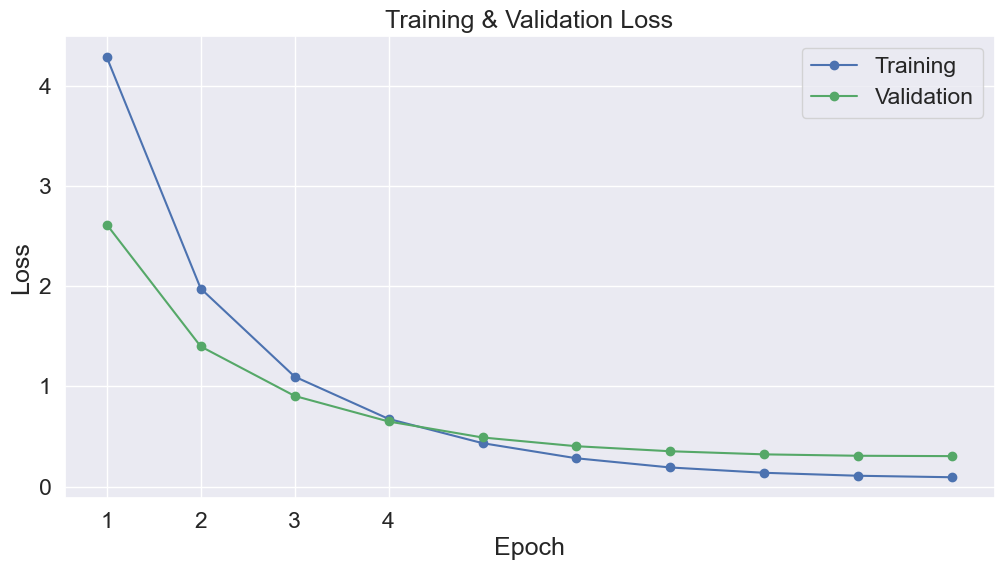

In [52]:
# seaborn 이용해서 그래프 출력
sns.set(style='darkgrid')

# 폰트 크기
sns.set(font_scale=1.5)

# 그림 크기
plt.rcParams["figure.figsize"] = (12,6)

# loss 출력
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# 축 이름 지정
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [53]:
# 테스트 셋에 대하여 평가해봐요

print("Predicting labels ...")

# 평가 모드로 진입
model.eval()

# 추적할 변수 선언
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # batch에 있는 하나하나에 gpu 할당을 해줌 + batch 변수에 다시 저장
  batch = tuple(t.to(device) for t in batch)
  
  # batch 안에 들어있는 ids, mask, labels들을 다 끄집어 냄
  b_input_ids, b_input_mask, b_labels = batch

  # 순전파만 돌리는거니 autograd 끔
  with torch.no_grad():
      outputs = model(input_ids=b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0] # 0번째는 logits가 들어있음

  # logits, label -> cpu로 할당
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # 추적할 변수들안에 계속 차곡차곡 쌓기
  predictions.extend(logits)
  true_labels.extend(label_ids)

print(f"Predicted {len(predictions)} samples")

Predicting labels ...
Predicted 2195 samples


In [54]:
predictions = np.argmax(predictions, axis=1)
print(f"Test set accuracy: {accuracy_score(true_labels, predictions)}")

# f1_score은 사용하는 혼동 행렬들이 적기 때문에 모든 혼동행렬 종류들이 반영된 점수를 쓰는게 더 좋을 수 있다
# ㄴ 0,1을 구별하는 이진 분류에서의 이야기임
print(f"Test set Matthews correlation coefficient: {matthews_corrcoef(true_labels, predictions)}")

Test set accuracy: 0.9453302961275627
Test set Matthews correlation coefficient: 0.9450713239791448


In [56]:
# save
save_dir = "model/kobert"
model.save_pretrained(save_dir)

In [7]:
# load
model2 = AutoModelForSequenceClassification.from_pretrained("model/kobert").cuda()

In [8]:
# load 파라미터(변경시 꼭 수정해야해!)
max_len = 152

In [21]:
# prediction
# 환불 때리고 싶은데 가능함?
# 휴대폰으로 결제하고 싶은데 어떻게 해야하나요?
# 비번 까먹었는데 어떻게 해야하나요?
# 대전 성심당에 빵 뭐 있는지 알고 싶어요
texts = ["빵 뭐 있는지 알고 싶어요"]

In [22]:
input_ids = []
attention_masks = []

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                          text,            
                          add_special_tokens = True,
                          max_length = max_len,
                          pad_to_max_length = True, # padding =True 나 padding="longest" 같은걸로 대체하세요
                          return_attention_mask = True,
                          return_tensors = 'pt')
  
  input_ids.append(encoded_dict['input_ids'])

  attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)


In [23]:
model2.eval()

predictions = []
last_layer_attentions = []

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

for i in range(len(input_ids)):

  ids = input_ids[i].unsqueeze(0)
  masks = attention_masks[i].unsqueeze(0)

  with torch.no_grad():
      outputs = model2(input_ids=ids,
                      attention_mask=masks)

  logits = outputs[0]
  logits = torch.softmax(logits,dim=1)
  last_layer_attention = outputs[1][-1]
  
  logits = logits.detach().cpu().numpy()
  last_layer_attention = last_layer_attention.detach().cpu().numpy()

  last_layer_attentions.append(last_layer_attention)
  predictions.append(logits)

In [24]:
probs = predictions[0][0]
print("text:", texts[0])
pred_idx = np.argmax(probs)
print(f"Prediction: {intent_list[pred_idx]} ({probs[pred_idx]:.2f})", )

text: 빵 뭐 있는지 알고 싶어요
Prediction: 상품검색 (0.97)


In [22]:
# ### 전체 pred 값 ###
# print("predictions:", probs)

predictions: [4.86108800e-03 9.30860732e-03 5.83432615e-04 4.94632288e-04
 2.52864230e-03 4.51085670e-03 7.46212376e-04 1.50000374e-03
 4.25411621e-03 4.64140021e-06 1.21743241e-02 5.52538596e-03
 4.60196825e-05 2.44575064e-03 1.31486345e-03 9.87582374e-04
 1.35614304e-04 1.21928228e-03 7.30044363e-08 7.53255546e-01
 7.94948358e-03 1.61351042e-03 1.00046273e-04 9.36795899e-04
 5.14498039e-04 2.78299376e-06 4.90002676e-05 1.44488840e-05
 8.78564492e-07 1.52675057e-04 2.19308655e-04 7.23765173e-04
 9.17103971e-05 6.71113139e-06 3.99483688e-05 2.34663108e-04
 2.18029363e-05 8.02992872e-06 4.60721776e-06 1.28025877e-05
 4.44860859e-07 1.61666117e-04 1.75775762e-03 2.47934368e-05
 7.09049171e-04 1.59003917e-04 1.14525551e-06 3.93450428e-05
 1.78237009e-04 6.60132901e-06 1.85203215e-04 1.36930448e-05
 4.57918350e-06 9.16206161e-04 4.96171531e-04 6.95055423e-05
 3.34485012e-05 2.48830853e-04 2.83344858e-03 1.74507426e-04
 1.53111439e-04 3.69201007e-05 2.20334827e-04 3.17534577e-04
 5.81522007